In [1]:
import cuml as cm
import cupy as cp
import cudf as cd
import numpy as np
import pandas as pd
import sklearn as sk
import lightgbm as lgb
print("ok")

ok


In [6]:
data = pd.read_excel("América do Sul_MODEL.xlsx", sheet_name='Sheet1')

cat_col_minus_oh = ["sex", "student_accommodation", "work", 
                    "income_grupos de referência pelo percentil_20,40,60,80,100",
                    "sedentary_behavior", 'sedentary_2']

one_hotted = ["marital_status", "gender_identity", "sexual_orientation", "country_code"]                
target_col = "gad7_class"

data = data.drop(columns=["continent_code", "country_code"])

X = data.drop(columns=[target_col])
y = data[target_col]

missing_data_idx = X[X.isna().any(axis=1)].index.to_numpy()
complete_data_idx = X.dropna().index.to_numpy()

df = pd.DataFrame(data)

df.to_excel("América do Sul_MODEL_treated.xlsx", index=False)
df.describe()

,age,sex,gender_identity,sexual_orientation,bmi,marital_status,student_accommodation,work,"income_grupos de referência pelo percentil_20,40,60,80,100",score_food_smile,score_subs_smile,score_Physical Activity_smile,score_stress_smile,score_social_smile,score_sleep_smile,score_envir_smile,sedentary_behavior,sedentary_2,gad7_class
count,7377.000000,7366.000000,7318.000000,7343.000000,7029.000000,7358.000000,7364.000000,7353.000000,6622.000000,7369.000000,7307.000000,7330.000000,7343.000000,7329.000000,7342.000000,7342.000000,7370.000000,7373.000000,7377.000000
mean,19.779992,0.397231,0.034299,0.633256,23.386815,1.081136,0.979223,0.806610,1.959680,7.571584,14.865608,7.366712,3.880567,12.844999,9.485835,8.605148,2.034600,1.119626,0.449641
std,3.087655,0.489358,0.182009,1.048884,4.493129,0.538142,0.142646,0.394983,1.418598,1.590574,1.610601,2.548647,1.546530,4.821286,4.571043,2.096251,1.015164,1.079484,0.497491
min,16.000000,0.000000,0.000000,0.000000,12.818459,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,3.000000,2.000000,3.000000,3.000000,4.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,20.312500,1.000000,1.000000,1.000000,1.000000,6.000000,14.000000,5.000000,3.000000,9.000000,6.000000,7.000000,1.000000,0.000000,0.000000
50%,19.000000,0.000000,0.000000,0.000000,22.666666,1.000000,1.000000,1.000000,2.000000,7.000000,15.000000,7.000000,4.000000,14.000000,8.000000,9.000000,2.000000,1.000000,0.000000
75%,20.000000,1.000000,0.000000,1.000000,25.461981,1.000000,1.000000,1.000000,3.000000,9.000000,16.000000,9.000000,5.000000,17.000000,12.000000,10.000000,3.000000,2.000000,1.000000
max,35.000000,1.000000,1.000000,4.000000,65.000000,4.000000,1.000000,1.000000,4.000000,12.000000,16.000000,12.000000,8.000000,20.000000,20.000000,16.000000,4.000000,4.000000,1.000000


In [9]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=50)
splits = []

one_hotted = ["marital_status", "gender_identity", "sexual_orientation", 'sex', 'student_accommodation', 'work']  

#cat_noh = ['sex', 'student_accommodation', 'work', 'sedentary_behavior','sedentary_2','income_grupos de referência pelo percentil_20,40,60,80,100']

num = ['age', 'bmi', 'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
       'score_stress_smile', 'score_social_smile', 'score_sleep_smile',
       'score_envir_smile',  'sedentary_behavior','sedentary_2',
       'income_grupos de referência pelo percentil_20,40,60,80,100']

for train_pos, test_pos in shuffle_split.split(complete_data_idx):
    train_idx = complete_data_idx[train_pos]
    test_idx = complete_data_idx[test_pos]

#    train_idx = pd.Index(train_idx).union(missing_data_idx)  

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # One-hot encoding e StandardScaler
    onehot_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    #scaler_transformer = MinMaxScaler(feature_range=(0, 1))
    scaler_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", onehot_transformer, one_hotted),
            ("scaler", scaler_transformer, num),
        ],
        remainder="passthrough"
    )

    #  codficando e escalonando
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    #nomeando as variáveis nos splits - melhor visualização
    onehot_names = preprocessor.named_transformers_["onehot"].get_feature_names_out(one_hotted)
    scaled_names = num

    remaining = [col for col in X_train.columns if col not in one_hotted + num]

    all_feature_names = np.concatenate([onehot_names, scaled_names, remaining])

    X_train = pd.DataFrame(X_train_transformed, index=X_train.index, columns=all_feature_names)
    X_test = pd.DataFrame(X_test_transformed, index=X_test.index, columns=all_feature_names)

    # guardando splits com os dados transformados
    splits.append({
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    })

# debugging: check do "transformer"
print(f"Treino: {splits[0]['X_train'].shape}, Teste: {splits[0]['X_test'].shape}")

Treino: (4839, 30), Teste: (1210, 30)


In [4]:
#knn_imputer = KNNImputer(n_neighbors=1)
#for split in splits:
#
#    X_train_imputed = pd.DataFrame(
#        knn_imputer.fit_transform(split["X_train"]),
#        columns=split["X_train"].columns,
#        index=split["X_train"].index
#    )
#
#    split["X_train_imputed"] = X_train_imputed
#print("ok")

ok


In [5]:
from scipy.stats import ks_2samp, chi2_contingency
c2 = ['marital_status_0.0', 'marital_status_1.0', 'marital_status_2.0',
       'marital_status_3.0', 'marital_status_4.0', 'marital_status_nan',
       'gender_identity_0.0', 'gender_identity_1.0', 'gender_identity_nan',
       'sexual_orientation_0.0', 'sexual_orientation_1.0',
       'sexual_orientation_2.0', 'sexual_orientation_3.0',
       'sexual_orientation_4.0', 'sexual_orientation_nan', "sex_0.0",	"sex_1.0",	"sex_nan",	"student_accommodation_0.0",	
       "student_accommodation_1.0",	"student_accommodation_nan",	"work_0.0",	"work_1.0",	"work_nan"] 

ks = ['age', 'bmi', 'income_grupos de referência pelo percentil_20,40,60,80,100', 
      'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
      'score_stress_smile', 'score_social_smile', 'score_sleep_smile',
      'score_envir_smile', 'sedentary_behavior','sedentary_2']

for i, split in enumerate(splits):

    X_train_imputed = splits[i]["X_train_imputed"]

    #testando a similaridade dos dados inputados vs originais
    for col in split["X_train"].columns:
        #teste KS para variáveis numéricas
        if col in ks:
            original_values = split["X_train"][col].dropna()
            imputed_values = X_train_imputed[col]

            ks_stat, p_value = ks_2samp(original_values, imputed_values)

            if p_value < 0.05: print(f"Variável {col}  NÃO tem distribuições similares (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} NÃO tem distribuições similares (proved null-hypothesis) - {p_value}")

        #chi-quadrado para testar variação entre categóricas
        elif col in c2:
            original_counts = split["X_train"][col].value_counts()
            imputed_counts = X_train_imputed[col].round().astype(int).value_counts()

            original_counts= original_counts.reindex(imputed_counts.index, fill_value=0)
            imputed_counts= imputed_counts.reindex(original_counts.index, fill_value=0)

            chi2, p_value, _, _ = chi2_contingency([original_counts, imputed_counts])

            if p_value < 0.05: print(f"Variável {col} AFETADA pela inputação (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} AFETADA pela inputação (proved null-hypothesis) - {p_value}")
print("ok")

ok


In [11]:
import cudf
import cupy as cp
import numpy as np
from imblearn.over_sampling import SMOTE
from cuml.ensemble import RandomForestClassifier as cuRFClassifier
from cuml.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score
import shap

acc_list = []
recall_list = []
f1_list = []
f1_beta_list = []
all_y_true = []
all_predictions = []
all_shap_values = []

smote = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=1)

for i, split in enumerate(splits):
    
    X_train_cudf = cudf.DataFrame(split['X_train_imputed'])
    X_test_cudf = cudf.DataFrame(split['X_test'])
    y_train_cudf = cudf.Series(split['y_train'])
    y_test_cudf = cudf.Series(split['y_test'])
    
    clf_rf = cuRFClassifier(
        n_estimators=130,
        max_depth=14,
        min_samples_leaf=3,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_streams=2.4
    )

    clf_rf.fit(X_train_cudf, y_train_cudf)
    predictions = clf_rf.predict(X_test_cudf)
    
    predictions_host = predictions.to_numpy() if hasattr(predictions, "to_numpy") else np.array(predictions)
    y_test_host = y_test_cudf.to_numpy() if hasattr(y_test_cudf, "to_numpy") else np.array(y_test_cudf)
    
    acc = accuracy_score(y_test_host, predictions_host)
    recall = recall_score(y_test_host, predictions_host, average='macro')
    
    print(f"Split {i+1} -- Accuracy: {acc:.3f}, Recall: {recall:.3f}")
    
    acc_list.append(acc)
    recall_list.append(recall)
    all_y_true.extend(y_test_host)
    all_predictions.extend(predictions_host)
    
#   explainer = shap.explainers.GPUTree(clf_rf)
#   s#hap_values = explainer.shap_values(X_test_cudf.to_numpy(), check_additivity=False)
#   for SHAPs in shap_values:
#       all_shap_values.append(SHAPs)
    
avg_acc = np.mean(acc_list)
avg_recall = np.mean(recall_list)

print("\nOverall Cross-Validation Metrics:")
print("Average Accuracy: {:.3f}".format(avg_acc))
print("Average Recall: {:.3f}".format(avg_recall))

#columns = splits[0]["X_train_imputed"].columns
#X_test = pd.DataFrame(X_test, columns=columns)
#X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)
#
#shap_df = cudf.DataFrame(shap_values[:, :, 1], columns = X_test.columns)
#shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
#X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()
#
#shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
#X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()
#
#shap.summary_plot(shap_df_aggregated.values, X_test_aggregated, max_display=50, plot_type="bar")

/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Split 1 -- Accuracy: 0.702, Recall: 0.697


/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Split 2 -- Accuracy: 0.674, Recall: 0.670


/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Split 3 -- Accuracy: 0.675, Recall: 0.671


/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Split 4 -- Accuracy: 0.663, Recall: 0.657


/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Split 5 -- Accuracy: 0.680, Recall: 0.676

Overall Cross-Validation Metrics:
Average Accuracy: 0.679
Average Recall: 0.674


In [13]:
#RandomForest - teste sem imputação/balanceamento
one_hotted = ["marital_status", "gender_identity", "sexual_orientation", 
              "country_code", 'sex', 'student_accommodation', 'work'] 

lifestyle = ['score_subs_smile', 'score_Physical Activity_smile', 'score_stress_smile', 
             'score_social_smile', 'score_sleep_smile','score_envir_smile', 'score_food_smile']

social_var = ["marital_status", "gender_identity", "sexual_orientation", 
              'sex', 'student_accommodation', 'work', 'income_pct', 'sedentary_behavior' , 'sedentary_2']

def one_hot_agg(name):
    for prefix in one_hotted:
        if name.startswith(prefix):
            return prefix
    return name

def aggregate_col(col):
    if col in lifestyle:
        return 'lifestyle'
    elif col in social_var:
        return 'social_var'
    else:
        return col

import matplotlib.pyplot as plt
import shap
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.decomposition import PCA

acc_train_list,  acc_test_list = [], []
recall_train_list, recall_test_list = [], []
roc_auc_train_list, roc_auc_test_list = [], []
all_y_true = []
all_predictions = []
all_shap_values = []

for i, split in enumerate(splits):
    
    X_train = split["X_train"]
    X_test = split['X_test']
    y_train = split["y_train"]
    y_test = split['y_test']
    
#    columns = splits[0]["X_test"].columns
#    X_test = pd.DataFrame(X_test, columns=columns)
#    X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

#   escrevi aqui os valores dos hiperparametros que utilizei, mais para guardar um histórico
#   GridSearch 1: (max_depth=10, min_samples_split=10, n_estimators=200) - 0.422

    clf_rf = RandomForestClassifier(
                                    n_estimators=150,
                                    max_depth=None,
                                    min_samples_split=5,
                                    min_samples_leaf=4,
                                    max_features='sqrt',
                                    class_weight='balanced',
                                    criterion='entropy',
                                    bootstrap=True)
    clf_rf.fit(X_train, y_train)
    
    pred_test = clf_rf.predict(X_test)
    pred_train = clf_rf.predict(X_train)
    
    y_train_pred_prob = clf_rf.predict_proba(X_train)[:, 1]
    y_test_pred_prob = clf_rf.predict_proba(X_test)[:, 1]

    acc_test = accuracy_score(y_test, pred_test)
    acc_train = accuracy_score(y_train, pred_train)
    
    recall_test = recall_score(y_test, pred_test, average='macro')
    recall_train = recall_score(y_train, pred_train, average='macro')
    
    #f1 = f1_score(y_test, predictions, average='macro')
    #f1_beta = fbeta_score(y_test, predictions, beta=0.5, average='macro')

    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    #print(f"Split {i+1} -- Accuracy: {acc:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F1-beta: {f1_beta:.3f}, ROC-AUC: {roc_auc:.3f}")
    print(f"Split {i+1}")
    print(f" -- Train Accuracy x Test Accuracy: {acc_train:.3f} x {acc_test:.3f}")
    print(f" -- Train Recall x Test Recall: {recall_train:.3f} x {recall_test:.3f}")
    print(f" -- Train ROC AUC x Test ROC AUC: {train_auc:.3f} x {test_auc:.3f}")

    acc_test_list.append(acc_test)
    acc_train_list.append(acc_train)
    recall_test_list.append(recall_test)
    recall_train_list.append(recall_train)
    #f1_list.append(f1)
    #f1_beta_list.append(f1_beta)
    roc_auc_test_list.append(test_auc)
    roc_auc_train_list.append(train_auc)
    
#    all_y_true.extend(y_test)
#    all_predictions.extend(predictions)

    explainer = shap.TreeExplainer(clf_rf)
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    for SHAPs in shap_values:
        all_shap_values.append(SHAPs)

avg_acc_train, avg_acc_test = np.mean(acc_train_list), np.mean(acc_test_list)
avg_recall_train, avg_recall_test = np.mean(recall_train_list), np.mean(recall_test_list)
#avg_f1 = np.mean(f1_list)
#avg_f1_beta = np.mean(f1_beta_list)
avg_roc_auc_score_train, avg_roc_auc_score_test = np.mean(roc_auc_train_list), np.mean(roc_auc_test_list)

print("\nOverall Cross-Validation Metrics:")
print(f"Average Accuracy: {avg_acc_train:.3f} x {avg_acc_test:.3f}")
print(f"Average Recall: {avg_recall_train:.3f} x {avg_recall_test:.3f}")
print(f"Average AUC-SCORE: {avg_roc_auc_score_train:.3f} x {avg_roc_auc_score_test:.3f}")
          
#print("Average Recall: {:.3f}".format(avg_recall))
#print("Average F1 Score: {:.3f}".format(avg_f1))
#print("Average F1-beta Score: {:.3f}".format(avg_f1_beta))
#print("Average ROC-AUC score: {:.3f}".format(avg_roc_auc_score))

## Compute and display the overall confusion matrix
#cm = confusion_matrix(all_y_true, all_predictions, labels=clf_rf.classes_)
#mtx = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
#mtx.plot(cmap="YlGnBu")
#plt.show()

columns = splits[0]["X_train_imputed"].columns
X_test = pd.DataFrame(X_test, columns=columns)
X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

shap_df = pd.DataFrame(shap_values[:, :, 1], columns = X_test.columns)
shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()

shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()

# Now call the SHAP summary plot with matching shapes:
shap.summary_plot(shap_df_agg.values, X_test_agg, max_display=50, plot_type="bar")

Split 1
 -- Train Accuracy x Test Accuracy: 0.893 x 0.702
 -- Train Recall x Test Recall: 0.893 x 0.702
 -- Train ROC AUC x Test ROC AUC: 0.964 x 0.773
Split 2
 -- Train Accuracy x Test Accuracy: 0.892 x 0.671
 -- Train Recall x Test Recall: 0.892 x 0.671
 -- Train ROC AUC x Test ROC AUC: 0.963 x 0.729
Split 3
 -- Train Accuracy x Test Accuracy: 0.886 x 0.683
 -- Train Recall x Test Recall: 0.885 x 0.681
 -- Train ROC AUC x Test ROC AUC: 0.961 x 0.749
Split 4
 -- Train Accuracy x Test Accuracy: 0.889 x 0.665
 -- Train Recall x Test Recall: 0.889 x 0.663
 -- Train ROC AUC x Test ROC AUC: 0.962 x 0.725
Split 5
 -- Train Accuracy x Test Accuracy: 0.887 x 0.679
 -- Train Recall x Test Recall: 0.887 x 0.679
 -- Train ROC AUC x Test ROC AUC: 0.962 x 0.744

Overall Cross-Validation Metrics:
Average Accuracy: 0.889 x 0.680
Average Recall: 0.889 x 0.679
Average AUC-SCORE: 0.962 x 0.744


KeyError: 'X_train_imputed'

Split 1 -- Accuracy: 0.705, Recall: 0.700, F1: 0.701, F1-beta: 0.701
Split 2 -- Accuracy: 0.674, Recall: 0.670, F1: 0.669, F1-beta: 0.669
Split 3 -- Accuracy: 0.689, Recall: 0.686, F1: 0.686, F1-beta: 0.687
Split 4 -- Accuracy: 0.669, Recall: 0.666, F1: 0.666, F1-beta: 0.666
Split 5 -- Accuracy: 0.666, Recall: 0.663, F1: 0.663, F1-beta: 0.664

Overall Cross-Validation Metrics:
Average Accuracy: 0.681
Average Recall: 0.677
Average F1 Score: 0.677
Average F1-beta Score: 0.677


/tmp/ipykernel_795/1710313173.py:115: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
/tmp/ipykernel_795/1710313173.py:116: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()
/tmp/ipykernel_795/1710313173.py:118: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
/tmp/ipykernel_795/1710313173.py:119: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()


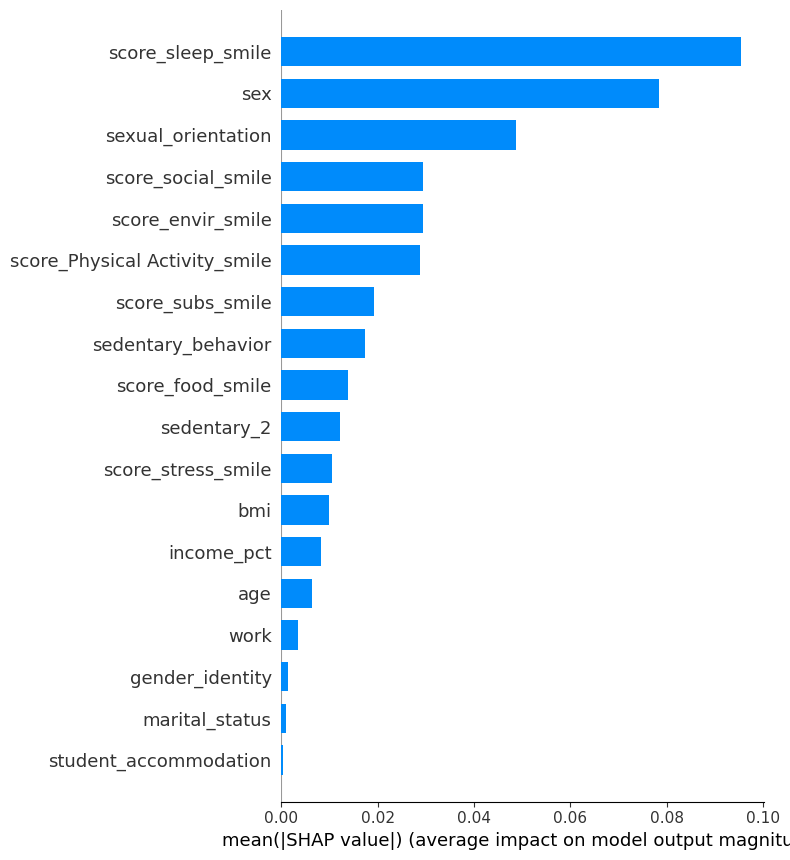

In [12]:
#RandomForest
one_hotted = ["marital_status", "gender_identity", "sexual_orientation", 
              "country_code", 'sex', 'student_accommodation', 'work'] 

lifestyle = ['score_subs_smile', 'score_Physical Activity_smile', 'score_stress_smile', 
             'score_social_smile', 'score_sleep_smile','score_envir_smile', 'score_food_smile']

social_var = ["marital_status", "gender_identity", "sexual_orientation", 
              'sex', 'student_accommodation', 'work', 'income_pct', 'sedentary_behavior' , 'sedentary_2']

def one_hot_agg(name):
    for prefix in one_hotted:
        if name.startswith(prefix):
            return prefix
    return name

def aggregate_col(col):
    if col in lifestyle:
        return 'lifestyle'
    elif col in social_var:
        return 'social_var'
    else:
        return col

import matplotlib.pyplot as plt
import shap
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.decomposition import PCA

smote = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=1)

acc_list = []
recall_list = []
f1_list = []
f1_beta_list = []
all_y_true = []
all_predictions = []
all_shap_values = []

for i, split in enumerate(splits):

    X_train = split['X_train_imputed']
    X_test = split['X_test']
    y_train = split['y_train']
    y_test = split['y_test']

    X_train_rs, y_train_rs = smote.fit_resample(X_train, y_train)
    
    #print("Distribuição de treino original:", np.bincount(y_train))
    #print("Distribuição de treino com resample", np.bincount(y_train_rs))
    
#    columns = splits[0]["X_test"].columns
#    X_test = pd.DataFrame(X_test, columns=columns)
#    X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

#   escrevi aqui os valores dos hiperparametros que utilizei, mais para guardar um histórico
#   GridSearch 1: (max_depth=10, min_samples_split=10, n_estimators=200) - 0.422

    clf_rf = RandomForestClassifier(
                                    n_estimators=150,
                                    max_depth=None,
                                    min_samples_split=5,
                                    min_samples_leaf=4,
                                    max_features='sqrt',
                                    criterion='entropy',
                                    bootstrap=True)
    clf_rf.fit(X_train_rs, y_train_rs)
    predictions = clf_rf.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    f1_beta = fbeta_score(y_test, predictions, beta=0.5, average='macro')
    
    print(f"Split {i+1} -- Accuracy: {acc:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F1-beta: {f1_beta:.3f}")

    acc_list.append(acc)
    recall_list.append(recall)
    f1_list.append(f1)
    f1_beta_list.append(f1_beta)
    
    all_y_true.extend(y_test)
    all_predictions.extend(predictions)

    explainer = shap.TreeExplainer(clf_rf)
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    for SHAPs in shap_values:
        all_shap_values.append(SHAPs)

avg_acc = np.mean(acc_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_f1_beta = np.mean(f1_beta_list)

print("\nOverall Cross-Validation Metrics:")
print("Average Accuracy: {:.3f}".format(avg_acc))
print("Average Recall: {:.3f}".format(avg_recall))
print("Average F1 Score: {:.3f}".format(avg_f1))
print("Average F1-beta Score: {:.3f}".format(avg_f1_beta))

## Compute and display the overall confusion matrix
#cm = confusion_matrix(all_y_true, all_predictions, labels=clf_rf.classes_)
#mtx = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
#mtx.plot(cmap="YlGnBu")
#plt.show()

columns = splits[0]["X_train_imputed"].columns
X_test = pd.DataFrame(X_test, columns=columns)
X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

shap_df = pd.DataFrame(shap_values[:, :, 1], columns = X_test.columns)
shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()

shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()

# Now call the SHAP summary plot with matching shapes:
shap.summary_plot(shap_df_agg.values, X_test_agg, max_display=50, plot_type="bar")

In [10]:
import cudf
import cupy as cp
import numpy as np
from cuml.ensemble import RandomForestClassifier as cuRFClassifier
from cuml.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score
import shap

acc_list = []
recall_list = []
all_y_true = []
all_predictions = []
all_shap_values = []

for i, split in enumerate(splits):
    
    X_train_cudf = cudf.DataFrame(split['X_train_imputed'])
    X_test_cudf = cudf.DataFrame(split['X_test'])
    y_train_cudf = cudf.Series(split['y_train'])
    y_test_cudf = cudf.Series(split['y_test'])

    X_train_cudf.columns = X_train_cudf.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    X_test_cudf.columns = X_test_cudf.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

    n_features = X_train_cudf.shape[1]
    colsample = np.sqrt(n_features) / n_features
    
    model = lgb.LGBMClassifier(
        n_estimators=130,
        max_depth=14,
        min_child_samples=3,
        colsample_bytree=colsample,
        random_state=42,
        device='gpu'
    )

    model.fit(X_train_cudf, y_train_np)
    predictions = model.predict(X_test_pd)
    
    #predictions_host = predictions.to_numpy() if hasattr(predictions, "to_numpy") else np.array(predictions)
    #y_test_host = y_test_np.to_numpy() if hasattr(y_test_cudf, "to_numpy") else np.array(y_test_cudf)
    
    acc = accuracy_score(y_test_cudf, predictions)
    recall = recall_score(y_test_np, predictions, average='macro')
    
    print(f"Split {i+1} -- Accuracy: {acc:.3f}, Recall: {recall:.3f}")
    
    acc_list.append(acc)
    recall_list.append(recall)
    all_y_true.extend(y_test_np)
    all_predictions.extend(predictions)

    explainer = shap.explainers.GPUTree(model)
    shap_values = explainer.shap_values(X_test_cudf.to_numpy(), check_additivity=False)
    for SHAPs in shap_values:
        all_shap_values.append(SHAPs)

avg_acc = np.mean(acc_list)
avg_recall = np.mean(recall_list)

print("\nOverall Cross-Validation Metrics:")
print("Average Accuracy: {:.3f}".format(avg_acc))
print("Average Recall: {:.3f}".format(avg_recall))

NameError: name 'y_train_np' is not defined

In [14]:
from skopt import BayesSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

recall_scorer = make_scorer(recall_score, average='macro')
recall_scores = []
best_params_list = []

class cuMLWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=185, max_depth=15, min_samples_leaf=4, max_features='log2', bootstrap=True, random_state=42, n_streams=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_streams=n_streams
    
    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = cudf.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = cudf.Series(y)
        self.estimator = cuRFClassifier(n_estimators=self.n_estimators,
                                        max_depth=self.max_depth,
                                        random_state=self.random_state,
                                        min_samples_leaf=self.min_samples_leaf,
                                        max_features=self.max_features,
                                        bootstrap=self.bootstrap,
                                        n_streams=1,
                                       )
        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = cudf.DataFrame(X)
        preds = self.estimator.predict(X)
        return preds.to_array() if hasattr(preds, 'to_array') else preds    
        
param_space = {
        'n_estimators': [100, 125, 150, 175, 200],
        'max_depth': [10, 15, 20],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'n_streams': [1, 2, 4],
        }

for i, split in enumerate(splits):
    X_train = split['X_train_imputed']
    y_train = split['y_train']
    X_test = split['X_test']
    y_test = split['y_test']
    
    bayes_cv = BayesSearchCV(
        estimator=cuMLWrapper(random_state=42),
        search_spaces=param_space,
        cv=5,                            # 3-fold cross-validation
        n_iter=10,                       # number of parameter settings to try
        scoring=recall_scorer,              # or another scoring metric as needed
        random_state=42
    )

    bayes_cv.fit(X_train, y_train)
    best_params_list.append(bayes_cv.best_params_)
    
    predictions = bayes_cv.predict(X_test)
    best_recall = recall_score(y_test, predictions, average='macro')
    recall_scores.append(best_recall)
    print(f"Split {i+1} - Best Parameters: {bayes_cv.best_params_}, Recall: {best_recall:.3f}")

avg_recall = sum(recall_scores) / len(recall_scores)
print(f"\nOverall Average Recall: {avg_recall:.3f}")

Split 1 - Best Parameters: OrderedDict({'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 150, 'n_streams': 1}), Recall: 0.689
Split 2 - Best Parameters: OrderedDict({'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 175, 'n_streams': 2}), Recall: 0.663
Split 3 - Best Parameters: OrderedDict({'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 175, 'n_streams': 2}), Recall: 0.690
Split 4 - Best Parameters: OrderedDict({'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 150, 'n_streams': 1}), Recall: 0.654
Split 5 - Best Parameters: OrderedDict({'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100, 'n_streams': 2}), Recall: 0.678

Overall Average Recall: 0.675


In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

recall_scorer = make_scorer(recall_score, average='macro')
recall_scores = []
best_params_list = []

class cuMLWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=185, max_depth=15, min_samples_leaf=4, max_features='log2', bootstrap=True, random_state=42, n_streams=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_streams=n_streams
    
    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = cudf.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = cudf.Series(y)
        self.estimator = cuRFClassifier(n_estimators=self.n_estimators,
                                        max_depth=self.max_depth,
                                        random_state=self.random_state,
                                        min_samples_leaf=self.min_samples_leaf,
                                        max_features=self.max_features,
                                        bootstrap=self.bootstrap,
                                        n_streams=1,
                                       )
        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = cudf.DataFrame(X)
        preds = self.estimator.predict(X)
        return preds.to_array() if hasattr(preds, 'to_array') else preds    
        
param_space = {
        'n_estimators': [100, 125, 150, 175, 200],
        'max_depth': [10, 15, 20],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'n_streams': [1, 2, 4],
        }

for i, split in enumerate(splits):
    X_train = split['X_train_imputed']
    y_train = split['y_train']
    X_test = split['X_test']
    y_test = split['y_test']
    
    random_search_cv = RandomizedSearchCV(
        estimator=cuMLWrapper(random_state=42),
        param_distributions=param_space,
        cv=10,                            # 3-fold cross-validation
        n_iter=20,                       # number of parameter settings to try
        scoring=recall_scorer,              # or another scoring metric as needed
        random_state=42
    )

    random_search_cv.fit(X_train, y_train)
    best_params_list.append(random_search_cv.best_params_)
    
    predictions = random_search_cv.predict(X_test)
    best_recall = recall_score(y_test, predictions, average='macro')
    recall_scores.append(best_recall)
    print(f"Split {i+1} - Best Parameters: {random_search_cv.best_params_}, Recall: {best_recall:.3f}")

avg_recall = sum(recall_scores) / len(recall_scores)
print(f"\nOverall Average Recall: {avg_recall:.3f}")

/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             

Split 1 - Best Parameters: {'n_streams': 1, 'n_estimators': 100, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}, Recall: 0.696
Split 2 - Best Parameters: {'n_streams': 2, 'n_estimators': 125, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}, Recall: 0.669
Split 3 - Best Parameters: {'n_streams': 4, 'n_estimators': 175, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}, Recall: 0.683
Split 4 - Best Parameters: {'n_streams': 4, 'n_estimators': 125, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}, Recall: 0.658
Split 5 - Best Parameters: {'n_streams': 1, 'n_estimators': 125, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}, Recall: 0.664

Overall Average Recall: 0.674


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

recall_scorer = make_scorer(recall_score, average='macro')
recall_scores = []
best_params_list = []

class cuMLWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=185, max_depth=15, min_samples_leaf=4, max_features='log2', bootstrap=True, random_state=42, n_streams=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_streams=n_streams
    
    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = cudf.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = cudf.Series(y)
        self.estimator = cuRFClassifier(n_estimators=self.n_estimators,
                                        max_depth=self.max_depth,
                                        random_state=self.random_state,
                                        min_samples_leaf=self.min_samples_leaf,
                                        max_features=self.max_features,
                                        bootstrap=self.bootstrap,
                                        n_streams=1,
                                       )
        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = cudf.DataFrame(X)
        preds = self.estimator.predict(X)
        return preds.to_array() if hasattr(preds, 'to_array') else preds    
        
param_space = {
        'n_estimators': [100, 125, 150, 175, 200],
        'max_depth': [10, 15, 20],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'n_streams': [1, 2, 4],
        }

for i, split in enumerate(splits):
    X_train = split['X_train_imputed']
    y_train = split['y_train']
    X_test = split['X_test']
    y_test = split['y_test']
    
    gridsearch_cv = GridSearchCV(
        estimator=cuMLWrapper(random_state=42),
        param_grid=param_space,
        cv=5,
        verbose=0
    )

    gridsearch_cv.fit(X_train, y_train)
    best_params_list.append(gridsearch_cv.best_params_)
    
    predictions = gridsearch_cv.predict(X_test)
    best_recall = recall_score(y_test, predictions, average='macro')
    recall_scores.append(best_recall)
    print(f"Split {i+1} - Best Parameters: {gridsearch_cv.best_params_}, Recall: {best_recall:.3f}")

avg_recall = sum(recall_scores) / len(recall_scores)
print(f"\nOverall Average Recall: {avg_recall:.3f}")

/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/base.py", line 572, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/tmp/ip